In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/data/str_images_symmetric.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/str_images_symmetric/train/origins/psp05_03_03_str_0003_948_900.jpg  
  inflating: /content/str_images_symmetric/train/origins/psp05_03_03_str_0004_835_469.jpg  
  inflating: /content/str_images_symmetric/train/origins/psp05_03_03_str_0005_273_1436.jpg  
  inflating: /content/str_images_symmetric/train/origins/psp05_03_03_str_0006_794_553.jpg  
  inflating: /content/str_images_symmetric/train/origins/psp05_03_03_str_0007_770_1565.jpg  
  inflating: /content/str_images_symmetric/train/origins/psp05_03_03_str_0008_832_582.jpg  
  inflating: /content/str_images_symmetric/train/origins/psp05_03_03_str_0009_909_1125.jpg  
  inflating: /content/str_images_symmetric/train/origins/psp05_03_03_str_0010_734_1393.jpg  
  inflating: /content/str_images_symmetric/train/origins/psp05_03_03_str_0011_762_552.jpg  
  inflating: /content/str_images_symmetric/train/origins/psp05_03_03_str_0012_383_1762.jpg  
  inflating: /content/st

In [ ]:
import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm

from timm import create_model
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

In [ ]:
# 1. Hyperparameters
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4
IMG_SIZE = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

In [ ]:
data_dir = "/content/str_images_symmetric"
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=transform)

# Create DataLoader instances for batching
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")

Training images: 9600
Validation images: 2400


In [ ]:
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse mapping

print("Class to Index Mapping:")
print(class_to_idx)

Class to Index Mapping:
{'fraud': 0, 'origins': 1}


In [ ]:
# 3. Vision Transformer Model
model = create_model('vit_base_patch16_224', pretrained=True, num_classes=2)
# Freeze the transformer encoder layers (everything except the classification head)
for name, param in model.named_parameters():
    if "head" not in name:  # "head" refers to the classification layer
        param.requires_grad = False

model = model.to(device)

# 4. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Track Metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
total_params = sum(p.numel() for p in model.parameters())

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 85800194
Trainable parameters: 1538


In [ ]:
for name, param in model.named_parameters():
    print(name)

cls_token
pos_embed
patch_embed.proj.weight
patch_embed.proj.bias
blocks.0.norm1.weight
blocks.0.norm1.bias
blocks.0.attn.qkv.weight
blocks.0.attn.qkv.bias
blocks.0.attn.proj.weight
blocks.0.attn.proj.bias
blocks.0.norm2.weight
blocks.0.norm2.bias
blocks.0.mlp.fc1.weight
blocks.0.mlp.fc1.bias
blocks.0.mlp.fc2.weight
blocks.0.mlp.fc2.bias
blocks.1.norm1.weight
blocks.1.norm1.bias
blocks.1.attn.qkv.weight
blocks.1.attn.qkv.bias
blocks.1.attn.proj.weight
blocks.1.attn.proj.bias
blocks.1.norm2.weight
blocks.1.norm2.bias
blocks.1.mlp.fc1.weight
blocks.1.mlp.fc1.bias
blocks.1.mlp.fc2.weight
blocks.1.mlp.fc2.bias
blocks.2.norm1.weight
blocks.2.norm1.bias
blocks.2.attn.qkv.weight
blocks.2.attn.qkv.bias
blocks.2.attn.proj.weight
blocks.2.attn.proj.bias
blocks.2.norm2.weight
blocks.2.norm2.bias
blocks.2.mlp.fc1.weight
blocks.2.mlp.fc1.bias
blocks.2.mlp.fc2.weight
blocks.2.mlp.fc2.bias
blocks.3.norm1.weight
blocks.3.norm1.bias
blocks.3.attn.qkv.weight
blocks.3.attn.qkv.bias
blocks.3.attn.proj.wei

In [ ]:
# Unfreeze the last transformer blocks and the classification head
for name, param in model.named_parameters():
    if "blocks.11.mlp.fc2" in name or "head" in name:
        param.requires_grad = True

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 85800194
Trainable parameters: 2361602


In [ ]:
import time

# Training loop
since = time.time()
best_val_accuracy = 0.0
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    # Zero the gradients
    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  train_loss = running_loss / len(train_loader)
  train_accuracy = 100 * correct / total
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  # Validation
  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  val_loss /= len(val_loader)
  val_accuracy = 100 * correct / total
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)
  # Save the best model based on validation accuracy
  if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      torch.save(model.state_dict(), os.path.join("best_model.pth"))
      print("Best model saved!")

  print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

total_time = time.time() - since
print(f"Total training time: {total_time:.2f}s")

Best model saved!
Epoch 1/20, Train Loss: 0.5473, Train Acc: 71.20%, Val Loss: 0.5413, Val Acc: 73.12%
Epoch 2/20, Train Loss: 0.4983, Train Acc: 75.42%, Val Loss: 0.5368, Val Acc: 73.12%
Best model saved!
Epoch 3/20, Train Loss: 0.4785, Train Acc: 76.70%, Val Loss: 0.5312, Val Acc: 73.38%
Best model saved!
Epoch 4/20, Train Loss: 0.4623, Train Acc: 78.00%, Val Loss: 0.5172, Val Acc: 74.42%
Epoch 5/20, Train Loss: 0.4558, Train Acc: 77.82%, Val Loss: 0.5271, Val Acc: 73.92%
Best model saved!
Epoch 6/20, Train Loss: 0.4465, Train Acc: 78.78%, Val Loss: 0.5193, Val Acc: 74.71%
Best model saved!
Epoch 7/20, Train Loss: 0.4377, Train Acc: 79.22%, Val Loss: 0.5258, Val Acc: 74.79%
Epoch 8/20, Train Loss: 0.4339, Train Acc: 79.64%, Val Loss: 0.5224, Val Acc: 74.71%
Epoch 9/20, Train Loss: 0.4281, Train Acc: 80.03%, Val Loss: 0.5273, Val Acc: 73.58%
Epoch 10/20, Train Loss: 0.4215, Train Acc: 80.22%, Val Loss: 0.5336, Val Acc: 73.83%
Epoch 11/20, Train Loss: 0.4145, Train Acc: 80.80%, Val Los

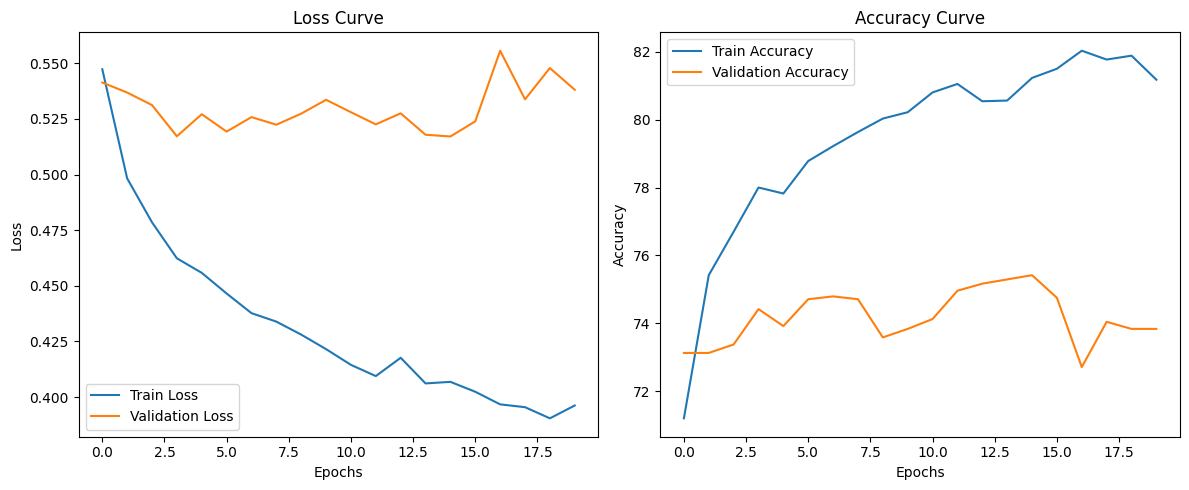

In [ ]:
# Plot Loss and Accuracy Curves
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label= 'Train Accuracy')
plt.plot(val_accuracies, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

**Prediction**

In [ ]:
best_model_path = "/content/best_model.pth"

model = create_model('vit_base_patch16_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load(best_model_path, map_location=device))  # Load saved weights
model = model.to(device).eval() # Evaluation mode

<ipython-input-20-afab5064642b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))  # Load saved weight

In [ ]:
def visualize_predictions(image_paths, model, transform, class_names, device='cuda'):
  """
  Visualizes predictions for 16 images in a 4x4 grid.

  Parameters:
    image_paths: List of 16 image file paths.
    model: The trained model for prediction.
    class_names: List of class names corresponding to the model output indices.
    device: The device to run the model ('cuda' or 'cpu').
  """
  fig, axes = plt.subplots(4, 4, figsize=(8, 8))
  axes = axes.flatten()  # Flatten the 2D axes array for easy indexing

  for idx, image_path in enumerate(image_paths):
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
      output = model(input_image)
      probabilities = torch.nn.functional.softmax(output[0], dim=0)  # Softmax for probabilities
      predicted_class_idx = torch.argmax(probabilities).item()  # Get the index of the highest probability
      predicted_label = class_names[predicted_class_idx]  # Map to class label
      confidence = probabilities[predicted_class_idx].item()

    # Display the image with prediction
    axes[idx].imshow(image)
    axes[idx].axis('off')
    axes[idx].set_title(f"Pred: {predicted_label}\nConf: {confidence:.2f}", fontsize=12, color='blue')

  # Hide any remaining axes (if fewer images are provided)
  for idx in range(len(image_paths), len(axes)):
    axes[idx].axis('off')

  plt.tight_layout()
  plt.show()

['/content/str_images_symmetric/test/fraud/psp07_01_02_str_0007_671_817.jpg', '/content/str_images_symmetric/test/fraud/psp09_04_02_str_0014_1112_1533.jpg', '/content/str_images_symmetric/test/fraud/psp05_05_01_str_0008_651_1108.jpg', '/content/str_images_symmetric/test/fraud/psp01_02_01_str_0005_773_534.jpg', '/content/str_images_symmetric/test/fraud/psp01_02_03_str_0026_503_1530.jpg', '/content/str_images_symmetric/test/fraud/psp07_01_01_str_0011_780_469.jpg', '/content/str_images_symmetric/test/fraud/psp08_04_01_str_0023_1052_1732.jpg', '/content/str_images_symmetric/test/fraud/psp04_03_01_str_0015_905_1134.jpg', '/content/str_images_symmetric/test/fraud/psp10_01_03_str_0004_763_1331.jpg', '/content/str_images_symmetric/test/fraud/psp02_03_01_str_0016_403_1753.jpg', '/content/str_images_symmetric/test/fraud/psp10_01_01_str_0015_531_1688.jpg', '/content/str_images_symmetric/test/fraud/psp05_05_01_str_0006_739_518.jpg', '/content/str_images_symmetric/test/fraud/psp05_05_02_str_0014_24

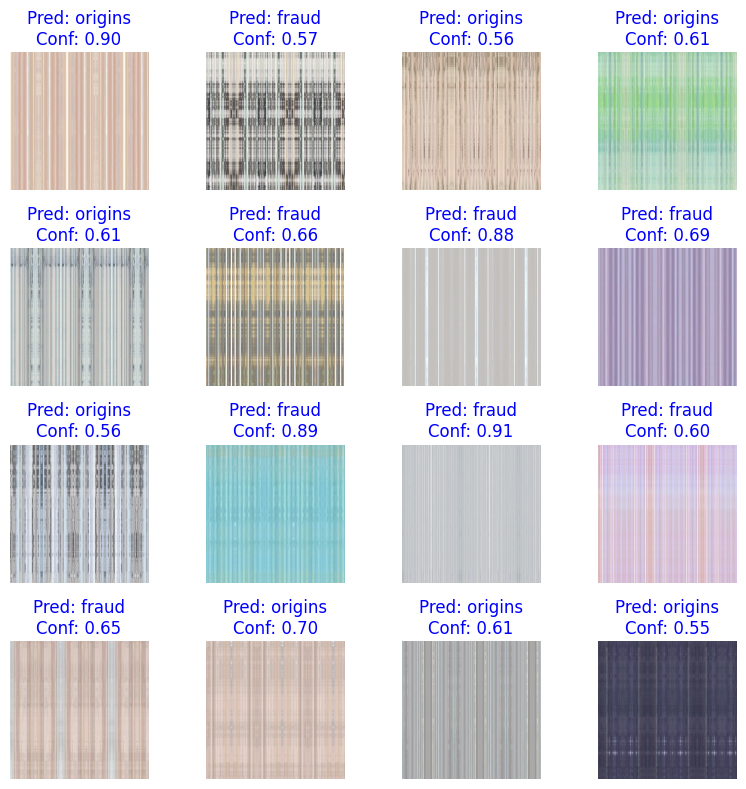

In [ ]:
test_folder = '/content/str_images_symmetric/test/fraud'
class_names = ['fraud', 'origins']
image_paths = os.listdir(test_folder)
test_image_paths = [os.path.join(test_folder, path) for path in image_paths][2:18]

print(test_image_paths)
visualize_predictions(test_image_paths, model, transform, class_names, device)


In [ ]:
test_dir = "/content/str_images_symmetric/val/origins"
images = os.listdir(test_dir)
image_paths = [os.path.join(test_dir, img) for img in images if img.endswith(('.jpg', '.png'))]
count_origins = 0
count_fraud = 0
for idx, image_path in enumerate(image_paths):
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
      output = model(input_image)
      probabilities = torch.nn.functional.softmax(output[0], dim=0)  # Softmax for probabilities
      predicted_class_idx = torch.argmax(probabilities).item()  # Get the index of the highest probability
      predicted_label = class_names[predicted_class_idx]  # Map to class label
      # print(predicted_label)
      if predicted_label == 'origins':
        count_origins += 1
      else:
        count_fraud += 1
      confidence = probabilities[predicted_class_idx].item()

print("Number random path original : ", count_origins)
print("Number random path fraud : ", count_fraud)

Number random path original :  877
Number random path fraud :  323


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def create_confusion_matrix(model, data_loader, class_names=("fraud", "origins")):
    """
    Evaluates the model on the validation set and creates a confusion matrix.

    Parameters:
        model: Trained model to evaluate.
        validation_loader: DataLoader for the validation set.
        class_names: Names of the classes (default: "fraud" and "origins").

    Returns:
        cm: The confusion matrix as a NumPy array.
    """
    # Set the model to evaluation mode
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, labels in data_loader:
            # Move inputs and labels to the appropriate device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Convert outputs to predicted classes
            _, preds = torch.max(outputs, 1)

            # Collect predictions and ground truth
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate all predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Generate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    #############################################

    # Normalize the confusion matrix to percentages
    cm_percentage = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

    # Display the confusion matrix with percentages
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.Blues)
    # plt.colorbar(im, ax=ax)

    # Add text annotations (percentages and raw counts)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm_percentage[i, j]:.2f}%\n({cm[i, j]})",
                    ha="center", va="center",
                    color="white" if cm_percentage[i, j] > 50 else "black")

    # Add labels, title, and axes
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

    return cm


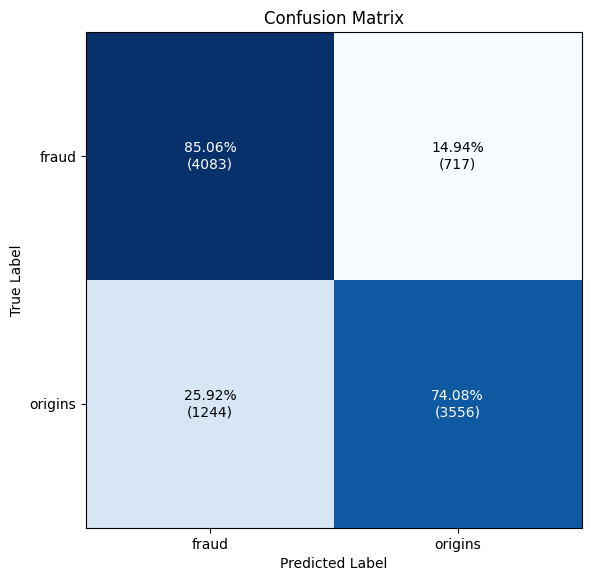

Confusion Matrix:
 [[4083  717]
 [1244 3556]]


In [ ]:
cm = create_confusion_matrix(model, train_loader, class_names=["fraud", "origins"])
print("Confusion Matrix:\n", cm)